In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [3]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [4]:
def forgetting(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum, tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    
    forgetting_arr = np.zeros(tasknum-1)
    for k in range(1,tasknum):
        forgetting_k = np.zeros(k)
        for j in range(k):
            forgetting_k[j] = np.max(acc_arr[:k,j]) - acc_arr[k,j]
        forgetting_arr[k-1] = np.mean(forgetting_k)
    
    return forgetting_arr

# CIFAR10/100

In [5]:
seed_num = 8
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
name = 'ICLR_split_cifar10_100_baye_{}_beta_{:.5f}_ratio_{:.4f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# beta_arr = [1e-3,1.5e-3,2e-3,2.5e-3,3e-3,3.5e-3,4e-3,4.5e-3]
# ratio_arr = [1/4,1/8]
beta_arr = [2.5e-3]
ratio_arr = [1/4]
for beta in beta_arr:
    UCL['A'][beta] = {}
    UCL['F'][beta] = {}
    for ratio in ratio_arr:
        UCL['A'][beta][ratio] = np.zeros((seed_num, 11))
        UCL['F'][beta][ratio] = np.zeros((seed_num, 10))
        for seed in range(seed_num):
            UCL['A'][beta][ratio][seed] = avg_acc(name.format(seed,beta,ratio), tasknum=11)
            UCL['F'][beta][ratio][seed] = forgetting(name.format(seed,beta,ratio), tasknum=11)

In [6]:
seed_num = 8
UCL_test = {}
UCL_test['A'] = {}
UCL_test['F'] = {}
name = 'TEST_split_cifar10_100_baye_{}_beta_{:.5f}_ratio_0.2500_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
beta_arr = [1e-3,1.5e-3,2e-3,2.5e-3,3e-3,3.5e-3,4e-3,4.5e-3]
for beta in beta_arr:
    UCL_test['A'][beta] = np.zeros((seed_num, 11))
    UCL_test['F'][beta] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        UCL_test['A'][beta][seed] = avg_acc(name.format(seed,beta), tasknum=11)
        UCL_test['F'][beta][seed] = forgetting(name.format(seed,beta), tasknum=11)

In [7]:
seed_num = 8
EWC = {}
EWC['A'] = {}
EWC['F'] = {}

name = 'ICLR_split_cifar10_100_ewc_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000, 25000, 50000, 75000, 100000]
lamb_arr = [50000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 11))
    EWC['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [8]:
seed_num = 8
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'ICLR_split_cifar10_100_si_{}_c_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# c_arr = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
c_arr = [0.75]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 11))
    SI['F'][c] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=11)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=11)

In [9]:
seed_num = 1
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}
name = 'ICLR_split_cifar10_100_rwalk_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lamb_arr = [11]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 11))
    RWALK['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [10]:
seed_num = 8
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'ICLR_split_cifar10_100_mas_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
lamb_arr = [1.4]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 11))
    MAS['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [11]:
seed_num = 1
HAT = {}
HAT['A'] = {}
HAT['F'] = {}
name = 'ICLR_split_cifar10_100_hat_{}_alpha_{}_smax_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
alpha_arr = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 4.0]
smax_arr = [400, 800]
for smax in smax_arr:
    HAT['A'][smax] = {}
    HAT['F'][smax] = {}
    for alpha in alpha_arr:
        HAT['A'][smax][alpha] = np.zeros((seed_num, 11))
        HAT['F'][smax][alpha] = np.zeros((seed_num, 10))
        for seed in range(seed_num):
            HAT['A'][smax][alpha][seed] = avg_acc(name.format(seed,alpha,smax),tasknum=11)
            HAT['F'][smax][alpha][seed] = forgetting(name.format(seed,alpha,smax),tasknum=11)

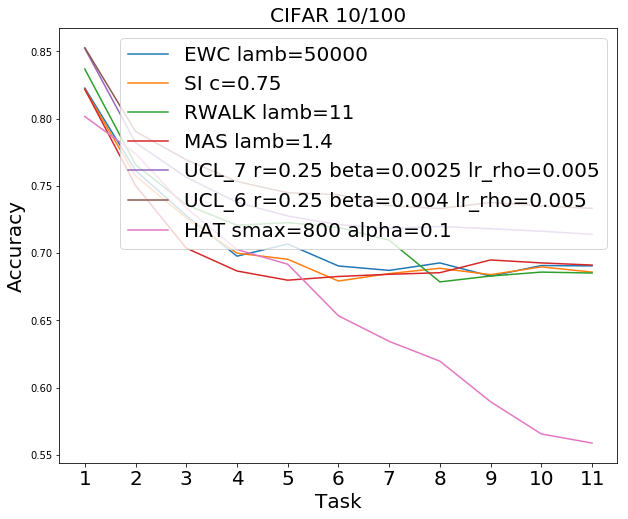

In [12]:
task = np.arange(11) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['A'][50000], axis = 0), linestyle='-', label='EWC lamb=50000')
plt.plot(task, np.mean(SI['A'][0.75], axis = 0), linestyle='-', label='SI c=0.75')
plt.plot(task, np.mean(RWALK['A'][11], axis = 0), linestyle='-', label='RWALK lamb=11')
plt.plot(task, np.mean(MAS['A'][1.4], axis = 0), linestyle='-', label='MAS lamb=1.4')
plt.plot(task, np.mean(UCL['A'][2.5e-3][1/4], axis = 0), linestyle='-', label='UCL_7 r=0.25 beta=0.0025 lr_rho=0.005')
plt.plot(task, np.mean(UCL_test['A'][0.004], axis = 0), linestyle='-', label='UCL_6 r=0.25 beta=0.004 lr_rho=0.005')
plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

        

plt.xticks([1,2,3,4,5,6,7,8,9,10,11], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)


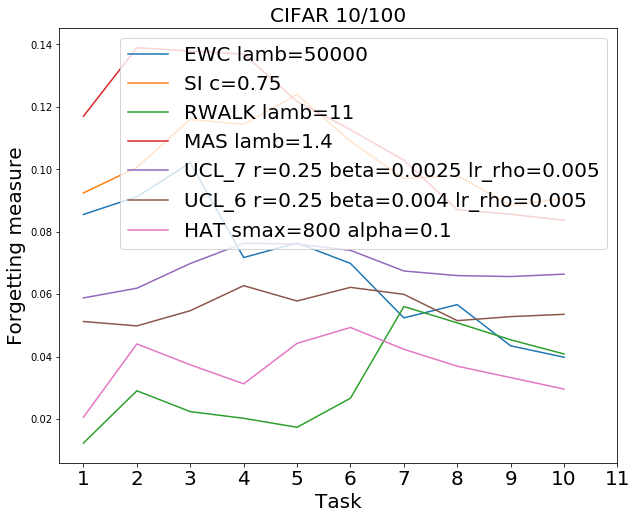

In [13]:
task = np.arange(10) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['F'][50000], axis = 0), linestyle='-', label='EWC lamb=50000')
plt.plot(task, np.mean(SI['F'][0.75], axis = 0), linestyle='-', label='SI c=0.75')
plt.plot(task, np.mean(RWALK['F'][11], axis = 0), linestyle='-', label='RWALK lamb=11')
plt.plot(task, np.mean(MAS['F'][1.4], axis = 0), linestyle='-', label='MAS lamb=1.4')
plt.plot(task, np.mean(UCL['F'][2.5e-3][1/4], axis = 0), linestyle='-', label='UCL_7 r=0.25 beta=0.0025 lr_rho=0.005')
plt.plot(task, np.mean(UCL_test['F'][0.004], axis = 0), linestyle='-', label='UCL_6 r=0.25 beta=0.004 lr_rho=0.005')
plt.plot(task, np.mean(HAT['F'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

plt.xticks([1,2,3,4,5,6,7,8,9,10,11], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Forgetting measure', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)



# 8 sequence of vision dataset

In [14]:
# seed_num = 1
# UCL = {}
# UCL['A'] = {}
# UCL['F'] = {}
# name = 'ICLR_split_cifar10_100_baye_{}_beta_{:.5f}_ratio_{:.4f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# # beta_arr = [1e-3,1.5e-3,2e-3,2.5e-3,3e-3,3.5e-3,4e-3,4.5e-3]
# # ratio_arr = [1/4,1/8]
# beta_arr = [2.5e-3]
# ratio_arr = [1/4]
# for beta in beta_arr:
#     UCL['A'][beta] = {}
#     UCL['F'][beta] = {}
#     for ratio in ratio_arr:
#         UCL['A'][beta][ratio] = np.zeros((seed_num, 11))
#         UCL['F'][beta][ratio] = np.zeros((seed_num, 11))
#         for seed in range(seed_num):
#             UCL['A'][beta][ratio][seed] = avg_acc(name.format(seed,beta,ratio), tasknum=8)
#             UCL['F'][beta][ratio][seed] = forgetting(name.format(seed,beta,ratio), tasknum=8)

In [15]:
seed_num = 8
EWC = {}
EWC['A'] = {}
EWC['F'] = {}
name = 'ICLR_mixture_ewc_{}_lamb_{:.1f}_lr_0.05_unitN_400_batch_64_epoch_150_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000,25000,50000,75000,100000]
lamb_arr = [50000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 8))
    EWC['F'][lamb] = np.zeros((seed_num, 7))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=8)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=8)

In [16]:
seed_num = 8
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'ICLR_mixture_si_{}_c_{}_lr_0.05_unitN_400_batch_64_epoch_150_conv.txt'
# c_arr = [25e-5,50e-5,75e-5,100e-5,25e-4,50e-4,75e-4,100e-4,25e-3,50e-3,75e-3,100e-3,25e-2,50e-2,75e-2,100e-2]
c_arr = [25e-4]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 8))
    SI['F'][c] = np.zeros((seed_num, 7))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=8)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=8)

In [17]:
seed_num = 8
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}
name = 'ICLR_mixture_rwalk_{}_lamb_{}_lr_0.05_unitN_400_batch_64_epoch_150_conv.txt'
# lamb_arr = [25e-5,50e-5,75e-5,100e-5,25e-4,50e-4,75e-4,100e-4,25e-3,50e-3,75e-3,100e-3,25e-2,50e-2,75e-2,100e-2]
lamb_arr = [25e-3]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 8))
    RWALK['F'][lamb] = np.zeros((seed_num, 7))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=8)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=8)

In [18]:
seed_num = 8
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'ICLR_mixture_mas_{}_lamb_{:.1f}_lr_0.05_unitN_400_batch_64_epoch_150_conv.txt'
# lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
lamb_arr = [3.2]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 8))
    MAS['F'][lamb] = np.zeros((seed_num, 7))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=8)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=8)

In [19]:
seed_num = 8
HAT = {}
HAT['A'] = {}
HAT['F'] = {}
name = 'ICLR_mixture_hat_{}_alpha_{}_smax_{}.0_lr_0.05_unitN_400_batch_64_epoch_150_conv.txt'
# alpha_arr = [0.1,0.25,0.5,0.75,1.0,1.5,2.5,4.0]
# smax_arr = [400,800]
alpha_arr = [0.1]
smax_arr = [400]
for smax in smax_arr:
    HAT['A'][smax] = {}
    HAT['F'][smax] = {}
    for alpha in alpha_arr:
        HAT['A'][smax][alpha] = np.zeros((seed_num, 8))
        HAT['F'][smax][alpha] = np.zeros((seed_num, 7))
        for seed in range(seed_num):
            HAT['A'][smax][alpha][seed] = avg_acc(name.format(seed,alpha,smax),tasknum=8)
            HAT['F'][smax][alpha][seed] = forgetting(name.format(seed,alpha,smax),tasknum=8)

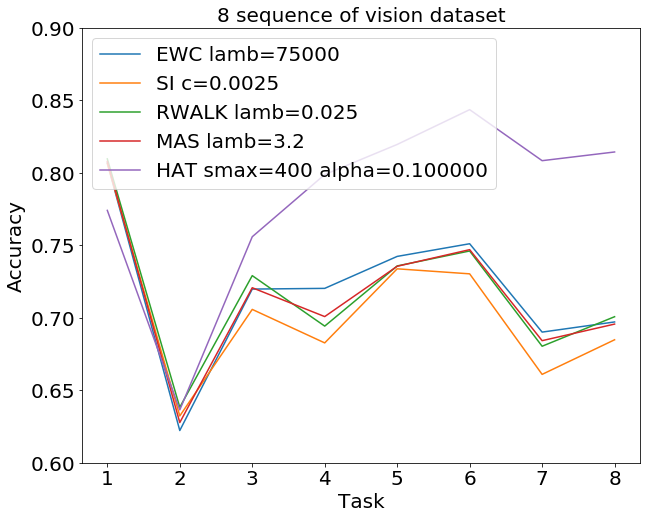

In [20]:
task = np.arange(8) + 1

plt.figure(figsize=(10,8))

plt.plot(task, np.mean(EWC['A'][50000], axis = 0), linestyle='-', label='EWC lamb=75000')
plt.plot(task, np.mean(SI['A'][25e-4], axis = 0), linestyle='-', label='SI c=0.0025')
plt.plot(task, np.mean(RWALK['A'][25e-3], axis=0), linestyle='-', label='RWALK lamb=0.025')
plt.plot(task, np.mean(MAS['A'][3.2], axis=0), linestyle='-', label='MAS lamb=3.2')
plt.plot(task, np.mean(HAT['A'][400][0.1], axis=0), linestyle = '-', label = 'HAT smax=%d alpha=%f'%(400,0.1))

plt.xticks([1,2,3,4,5,6,7,8], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim(0.6,0.9)
plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('8 sequence of vision dataset', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)

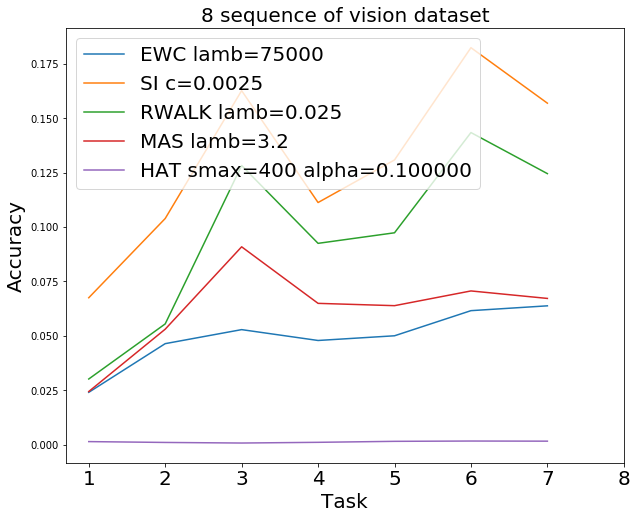

In [21]:
task = np.arange(7) + 1

plt.figure(figsize=(10,8))

plt.plot(task, np.mean(EWC['F'][50000], axis = 0), linestyle='-', label='EWC lamb=75000')
plt.plot(task, np.mean(SI['F'][25e-4], axis = 0), linestyle='-', label='SI c=0.0025')
plt.plot(task, np.mean(RWALK['F'][25e-3], axis=0), linestyle='-', label='RWALK lamb=0.025')
plt.plot(task, np.mean(MAS['F'][3.2], axis=0), linestyle='-', label='MAS lamb=3.2')
plt.plot(task, np.mean(HAT['F'][400][0.1], axis=0), linestyle = '-', label = 'HAT smax=%d alpha=%f'%(400,0.1))

plt.xticks([1,2,3,4,5,6,7,8], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('8 sequence of vision dataset', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)

